# Preparation

Firstly you need to load pre-trained model itself from this link:
https://drive.google.com/file/d/1PknQ5p97prnB7yifw2oVbQFzjrflQ3qk/view?usp=sharing

In [1]:
import os
os.chdir('..')
os.getcwd()

'/beegfs/home/m.kabir/BrainBERT/BrainBERT-master'

In [2]:
import sys
import models
from omegaconf import OmegaConf
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import torch
import sklearn as sk
from sklearn import *

In [3]:
EEG_spect = np.load("./sk_imageReconstructon/EEG_spectrograms.npy")
labels = np.load("./sk_imageReconstructon/labels.npy")

In [4]:
## loading model
device = 'cuda'
def build_model(cfg):
    ckpt_path = cfg.upstream_ckpt
    init_state = torch.load(ckpt_path)
    upstream_cfg = init_state["model_cfg"]
    print(upstream_cfg)
    upstream = models.build_model(upstream_cfg)
    return upstream

def load_model_weights(model, states, multi_gpu):
    if multi_gpu:
        model.module.load_weights(states)
    else:
        model.load_weights(states)

ckpt_path = "./pretrained_weights/stft_large_pretrained.pth"
cfg = OmegaConf.create({"upstream_ckpt": ckpt_path})
print(cfg)
tf_model = build_model(cfg)
tf_model.to(device)
init_state = torch.load(ckpt_path)
load_model_weights(tf_model, init_state['model'], False)


print(tf_model)

class MaskedTFClassifier(torch.nn.Module):
    def __init__(self, base_model: torch.nn.Module, num_classes):
        super(MaskedTFClassifier, self).__init__()
        self.base_model = base_model

        
        self.base_model.spec_prediction_head = torch.nn.Identity()

       
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(768, 768),
            torch.nn.LayerNorm(768),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),

            torch.nn.Linear(768, 512),
            torch.nn.LayerNorm(512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),

            torch.nn.Linear(256, 64),
            torch.nn.ReLU(),

            torch.nn.Linear(64, num_classes)  # No softmax here (handled in loss)
        )

    def forward(self, input_specs, src_key_mask,inter_state):

        transformer_output = self.base_model(
            input_specs=input_specs,
            src_key_mask=src_key_mask,
            intermediate_rep=True
        )  # shape: [batch, seq, 768]
        
        if inter_state:
            return transformer_output

        pooled = transformer_output.mean(dim=1)  # [batch, 768]

        return self.classifier(pooled)
    
# selected_model = MaskedTFClassifier(tf_model, num_classes=3)


def training(model,criteria,optimizer,training_data,num_epochs):
    train_losses = []
    for epoch in range(num_epochs):    
        model.train()
        train_loss = 0.0
        
        for param in model.base_model.spec_prediction_head.parameters():
            param.requires_grad = False
            
        # if epoch >= 200:
        #     for param in model.base_model.parameters():
        #         param.requires_grad = False
                
        for batch_X,batch_mask, batch_y in training_data:
            batch_X, batch_mask, batch_y = batch_X.to(device),batch_mask.to(device),  batch_y.to(device).long() 
            batch_mask = torch.zeros((batch_X.shape[:2])).bool().to(device)
            
            outputs = model(batch_X, batch_mask,inter_state=False)
            # print(outputs.shape)
            loss = criteria(outputs,batch_y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss +=loss.item()

            
        train_loss /=len(training_data)
        train_losses.append(train_loss)

        if (epoch+1)% 5 ==0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss = {train_loss:.4f}')
            
    plt.figure(figsize=(10,6))
    plt.plot(train_losses,label = "Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model
            
            
            
        
    

{'upstream_ckpt': './pretrained_weights/stft_large_pretrained.pth'}


/tmp/ipykernel_337585/2097289333.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  init_state = torch.load(ckpt_path)


{'name': 'masked_tf_model', 'hidden_dim': 768, 'layer_dim_feedforward': 3072, 'layer_activation': 'gelu', 'nhead': 12, 'encoder_num_layers': 6, 'input_dim': 40}
masked_tf_model
{'deep_linear_wav_baseline': <class 'models.deep_linear_wav_baseline.DeepLinearWavModel'>, 'feature_extract_hidden_model': <class 'models.feature_extract_hidden.FeatureExtractHiddenModel'>, 'finetune_model': <class 'models.finetune_model.FinetuneModel'>, 'linear_spec_baseline': <class 'models.linear_spec_baseline.LinearSpecModel'>, 'feature_extract_deep_model': <class 'models.feature_extract_deep_model.FeatureExtractDeepModel'>, 'linear_wav_baseline': <class 'models.linear_wav_baseline.LinearWavModel'>, 'masked_tf_model': <class 'models.masked_tf_model.MaskedTFModel'>, 'feature_extract_model': <class 'models.feature_extract_model.FeatureExtractModel'>, 'seeg_wav2vec': <class 'models.seeg_wav2vec.SeegWav2Vec'>, 'hidden_linear_wav_baseline': <class 'models.hidden_linear_wav_model.HiddenLinearWavBaseline'>}


/trinity/home/m.kabir/.local/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_337585/2097289333.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`

MaskedTFModel(
  (input_encoding): TransformerEncoderInput(
    (in_proj): Linear(in_features=40, out_features=768, bias=True)
    (positional_encoding): PositionalEncoding()
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
   

In [5]:
EEG_spect.shape

(10, 2, 14, 63, 40, 321)

In [6]:
np.unique(np.sort(labels.reshape(-1)),return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 array([ 7, 14, 16, 31, 21, 23, 22, 23, 26, 25, 26, 28, 18]))

In [11]:
X_temp = EEG_spect[0,:,:,1,:,:]
y_temp = labels[0,:,:]
y_original = labels[0,:,:].reshape(-1)
X_temp.shape, np.unique(y_temp.reshape(-1))

((2, 14, 40, 321), array([ 1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 10., 11.]))

In [12]:
print(np.unique(y_original)), y_original

[ 1.  2.  3.  4.  5.  6.  8.  9. 10. 11.]


(None,
 array([ 9., 10., 10.,  9., 10.,  4., 10.,  6.,  2.,  6.,  2., 11.,  6.,
        11., 11., 11., 11.,  9.,  9.,  8.,  8.,  3.,  5.,  5.,  3.,  3.,
         3.,  1.]))

In [13]:
unique_classes = np.unique(y_temp)   # sorted unique values
print("Unique classes in dataset:", unique_classes)


old_to_new = {old: new for new, old in enumerate(unique_classes)}
print("Mapping:", old_to_new)


y_temp = np.vectorize(old_to_new.get)(y_temp)

print("Mapped labels:", y_temp)

Unique classes in dataset: [ 1.  2.  3.  4.  5.  6.  8.  9. 10. 11.]
Mapping: {1.0: 0, 2.0: 1, 3.0: 2, 4.0: 3, 5.0: 4, 6.0: 5, 8.0: 6, 9.0: 7, 10.0: 8, 11.0: 9}
Mapped labels: [[7 8 8 7 8 3 8 5 1 5 1 9 5 9]
 [9 9 9 7 7 6 6 2 4 4 2 2 2 0]]


In [14]:
## Loading data
X  = X_temp.reshape(-1,X_temp.shape[-2],X_temp.shape[-1])
print(X.shape)

# Transposing to shuffle timestepms and freq bins
X = X.transpose(0, 2, 1)
print(X.shape)

# To tensor
X = torch.FloatTensor(X)
X.to(device)
print(X.shape)


# Loading y
y = torch.Tensor(y_temp.reshape(-1))
print(y.shape)
# creating mask
mask = torch.rand(X.shape[0], X.shape[1]) < 0.15
print(mask.shape)
# print(y)

(28, 40, 321)
(28, 321, 40)
torch.Size([28, 321, 40])
torch.Size([28])
torch.Size([28, 321])


In [15]:
np.unique(y)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32)

In [16]:
len(np.unique(y))

10

In [17]:
max(y)

tensor(9.)

Epoch [5/270], Train Loss = 2.2929
Epoch [10/270], Train Loss = 2.2616
Epoch [15/270], Train Loss = 2.2267
Epoch [20/270], Train Loss = 2.1965
Epoch [25/270], Train Loss = 2.0703
Epoch [30/270], Train Loss = 1.9826
Epoch [35/270], Train Loss = 1.8408
Epoch [40/270], Train Loss = 1.7256
Epoch [45/270], Train Loss = 1.5497
Epoch [50/270], Train Loss = 1.3979
Epoch [55/270], Train Loss = 1.2816
Epoch [60/270], Train Loss = 1.1592
Epoch [65/270], Train Loss = 0.9814
Epoch [70/270], Train Loss = 0.8373
Epoch [75/270], Train Loss = 0.7054
Epoch [80/270], Train Loss = 0.6191
Epoch [85/270], Train Loss = 0.5161
Epoch [90/270], Train Loss = 0.3893
Epoch [95/270], Train Loss = 0.3258
Epoch [100/270], Train Loss = 0.2566
Epoch [105/270], Train Loss = 0.1999
Epoch [110/270], Train Loss = 0.1653
Epoch [115/270], Train Loss = 0.1210
Epoch [120/270], Train Loss = 0.1040
Epoch [125/270], Train Loss = 0.0852
Epoch [130/270], Train Loss = 0.0824
Epoch [135/270], Train Loss = 0.0609
Epoch [140/270], Trai

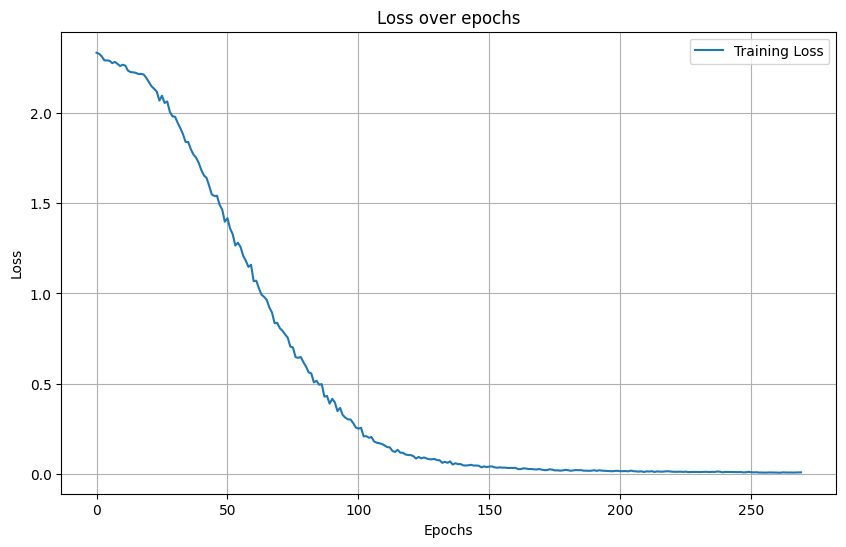

In [18]:
train_dataset = torch.utils.data.TensorDataset(X,mask,y)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)

selected_model = MaskedTFClassifier(tf_model, num_classes=len(np.unique(y)))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
selected_model.to(device)

selected_criteria  = torch.nn.CrossEntropyLoss()
selected_optimizer = torch.optim.AdamW(selected_model.parameters(),lr=1e-4,weight_decay=1e-2)

trained_model = training(model= selected_model,
                                 criteria = selected_criteria,
                                 optimizer=selected_optimizer,
                                 training_data= train_loader,
                                 # validation_data = val_loader,
                                 num_epochs = 270)


In [19]:
X.shape

torch.Size([28, 321, 40])

In [20]:
mask = torch.zeros((X.shape[:2])).bool().to(device)
print(mask.shape)

torch.Size([28, 321])


In [21]:
trained_model.eval()
with torch.no_grad():
    out = trained_model.forward(X.to(device), mask, inter_state=True)
    
out.shape

torch.Size([28, 321, 768])

In [22]:
out_reshaped = out.reshape(-1,out.shape[2])
out_reshaped.shape

torch.Size([8988, 768])

In [23]:
scaler = sk.preprocessing.StandardScaler()
out_transformed = scaler.fit_transform(out_reshaped.cpu()).reshape(out.shape)
print(out_transformed.shape)

(28, 321, 768)


In [24]:
pca = sk.decomposition.PCA()
out_pca = pca.fit_transform(out_transformed.reshape(out_reshaped.shape)).reshape(out.shape)
print(out_pca.shape)

(28, 321, 768)


In [25]:
np.unique(y),len(y)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32), 28)

In [26]:
np.unique(y_original),len(y_original)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  8.,  9., 10., 11.]), 28)

1.0
2.0
3.0
4.0
5.0
6.0
8.0
9.0
10.0
11.0


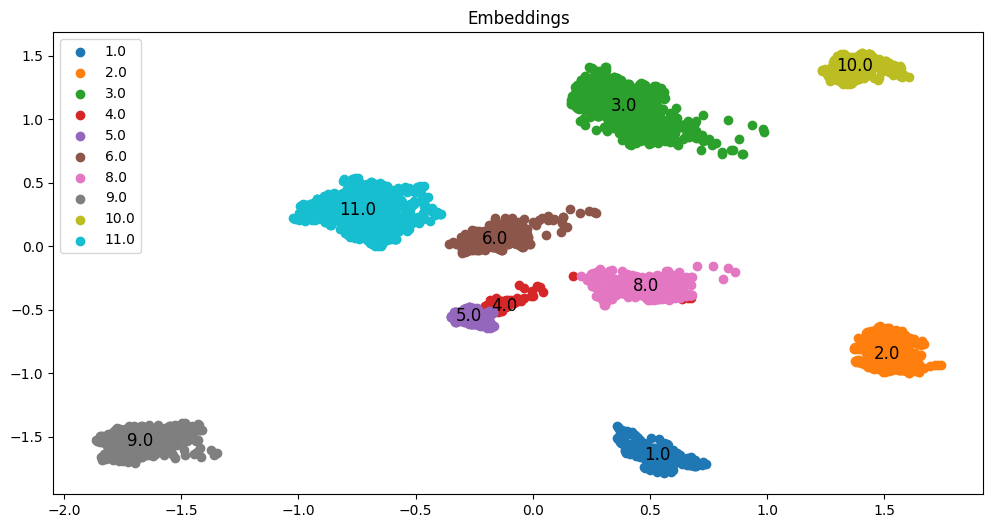

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))

for label in np.unique(y_original): 
    print(label)
    x = out_transformed[y_original == label, :, 0].flatten()
    z = out_transformed[y_original == label, :, 1].flatten()
    

    plt.scatter(x, z, alpha=1, label=str((label)))
    

    cx, cy = np.mean(x), np.mean(z)
    

    plt.text(cx, cy, str(label), fontsize=12,
             ha='center', va='center', color='black')

plt.title("Embeddings")
plt.legend()
plt.show()


1.0
2.0
3.0
4.0
5.0
6.0
8.0
9.0
10.0
11.0


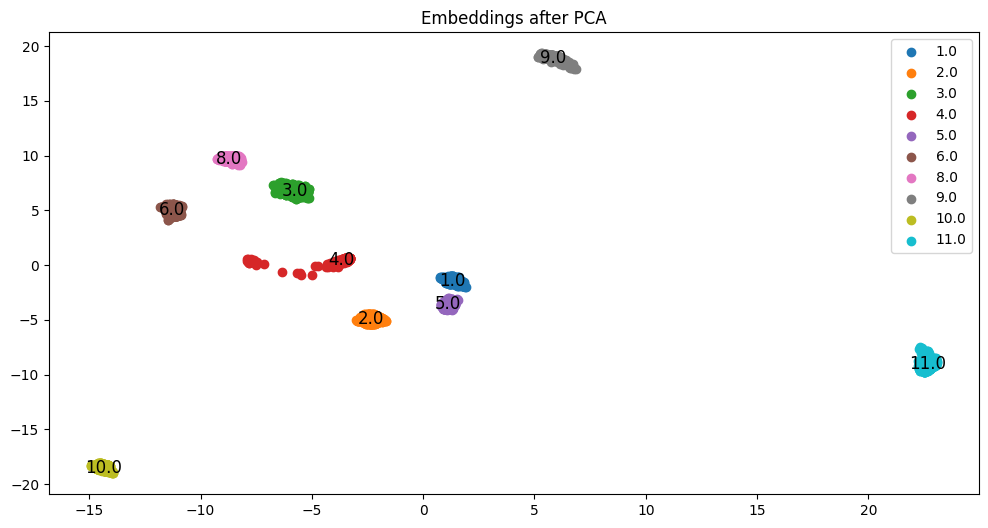

In [29]:
plt.figure(figsize=(12, 6))

for label in np.unique(y_original): 
    print(label)
    x = out_pca[y_original == label, :, 0].flatten()
    z = out_pca[y_original == label, :, 1].flatten()
    

    plt.scatter(x, z, alpha=1, label=str((label)))
    

    cx, cy = np.mean(x), np.mean(z)
    

    plt.text(cx, cy, str(label), fontsize=12,
             ha='center', va='center', color='black')

plt.title("Embeddings after PCA")
plt.legend()
plt.show()